In [1]:
import torch
from dpp_nets.my_torch.simulator2 import SimulClassifier
from dpp_nets.helper.plotting import plot_floats, plot_dict


In [21]:
# Global Settings
input_set_size = 15
aspects_n = 5
dtype = torch.DoubleTensor
path = '/Users/Max/Desktop/master thesis/latex/figures/plots'

fname = None  
title = 'Loss over Time'
xlabel = 'Training Steps'
ylabel = 'BCELoss'

reg=10
reg_mean = 5

train_steps = 5000
batch_size = 20
lr = 1e-3
reg=100
reg_mean = aspects_n
sample_iter = 5

In [23]:
# Multi-Sample + Baseline
# Reg is already scaled by sample_iter :)
torch.manual_seed(0)
best = SimulClassifier(input_set_size, aspects_n, dtype)
best.train(train_steps, batch_size, 5, baseline=True, lr=1e-3, reg=1, reg_mean=reg_mean)
best.evaluate(1000)

0.3146324043291008
0.2509389433191806
0.24115184618194171
0.19453388161644689
0.19788685400730516
0.1627976624685453
0.17485923313812302
0.1720812090439842
0.17089567708597714
0.1860854892427818
0.16875201946509763
0.16764194443693178
0.13750434637750847
0.13651470084341558
0.1438523153155891
0.14304883459600407
0.13663397139767158
0.14371937844820523
0.11738748144272661
0.15754224203575953
0.13982902703987843
0.12462123534458566
0.18624917380453365
0.1476378169162045
0.1263829783776641
0.18108369531777727
0.1181084015661828
0.12585857447116985
0.13269097797478943
0.17424595612523386
0.11316543890177164
0.11603939198053767
0.12131542314753878
0.1200231712493502
0.1551015722121454
0.12308858340490084
0.11684002641357409
0.1305026125970064
0.11234764846387903
0.13327026110500845
0.1106252095578349
0.11792319612750153
0.11337516839134659
0.13977149729294513
0.15124667151311477
0.16682852740488102
0.10527590538997975
0.14936526972323758
0.15239220142473425
0.12485960169751426
Loss: 0.11437

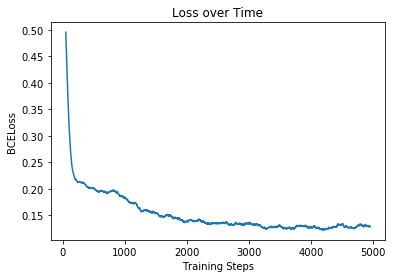

In [25]:
# Plots
plot_floats(best.loss_dict, 100, fname, title, xlabel, ylabel)

In [26]:
# Pure Reinforce
torch.manual_seed(0)
pure_reinforce = SimulClassifier(input_set_size, aspects_n, dtype)
pure_reinforce.train(train_steps, batch_size, 1, baseline=False, lr=lr, reg=reg, reg_mean=reg_mean)
pure_reinforce.evaluate(1000)

0.4529880745355033
0.2923851134887452
0.27710466249917776
0.1964949544250091
0.32073829215040883
0.27013666189250585
0.2201889488999825
0.28268772324739094
0.2555192369211301
0.3149611828062215
0.1401187606730852
0.3685850484763339
0.1831653672353092
0.23182783842535876
0.23554200774999448
0.1594890970709661
0.30922404526198877
0.19833164925601723
0.2063350899765941
0.21846008089411167
0.28654518166688947
0.1804741477249642
0.20884873753586333
0.2211317253025585
0.19120940752021334
0.13936796195111484
0.25877924054318124
0.1659523584681171
0.16421288018081207
0.17716988540260098
0.22774765539988215
0.17732152020210754
0.1991138337513238
0.21381506171075282
0.20447183373101735
0.15439799309609878
0.19921318466065002
0.14321658421440694
0.16630973031653332
0.18754684637855878
0.18623546014432862
0.17530044339924872
0.22324245225418565
0.21739527672168218
0.23180402522221272
0.16991117129036373
0.19903172756229606
0.17069542978261715
0.18653031982837648
0.13831506698426554
Loss: 0.1969421

In [34]:
plot_floats(pure_reinforce.loss_dict, 10, fname, title, xlabel, ylabel)

0.042980946477071076 0.9793999999999983 0.5925 0.9479999999999963 8.0


In [ ]:
# Multi-Sampling
torch.manual_seed(0)
multi = SimulClassifier(input_set_size, aspects_n, dtype)
multi.train(train_steps, batch_size, sample_iter, baseline=False, lr=lr, reg=reg, reg_mean=reg_mean)
multi.evaluate(1000)
plot_floats(multi.loss_dict, 10, fname, title, xlabel, ylabel)

In [5]:
### Now the Big Evaluation of the 4 models to see how it looks.

# Training Settings for Comparison Purposes
train_steps = 2000
batch_size = 20
lr = 1e-3
reg=100
reg_mean = aspects_n
sample_iter = 5

In [6]:
# Pure Reinforce
torch.manual_seed(0)
pure_reinforce = SimulClassifier(input_set_size, aspects_n, dtype)
pure_reinforce.evaluate(1000)
pure_reinforce.train(5000, batch_size, 1, baseline=False, lr=lr, reg=reg, reg_mean=reg_mean)

#pure_reinforce.evaluate(1000)
#plot_floats(pure_reinforce.loss_dict, 100, fname, title, xlabel, ylabel)

Loss: 0.6943795970701252 Pred Acc: 0.5042000000000009 Precision: 0.33003333333333323 Recall: 0.125600000000001 Set Size: 1.901
0.32344495337508095
0.3403809488259556
0.2551450198632196
0.21321289068280716
0.33658633629629436
0.20308584454987968
0.19030784663885228
0.23489811709862307
0.3115316467078893
0.248049967705177
0.30088114905399566
0.17684942685927507
0.15226566418685772
0.16966393672701918
0.1996354619601778
0.23716160374196846
0.29561865282229827
0.22602187002784097
0.24287338284317173
0.2367733920405707
0.2249083200727897
0.20570016199267785
0.18225324437781926
0.1903976020385351
0.14780845406479756
0.18804707818896566
0.24913548013479864
0.1886524164166894
0.22845100565286622
0.20561835216698549
0.19236601622303845
0.21882809947557647
0.14282851141645408
0.1924417780334957
0.17185483542726726
0.17707738331627504
0.18993753615148504
0.132921498941439
0.24015571107275466
0.24660104722138784
0.1591246444152233
0.19468018901802245
0.17759491937228009
0.2119507981773813
0.138450

In [13]:
plot_floats(pure_reinforce.loss_dict, 100, fname, title, xlabel, ylabel)

NameError: name 'pure_reinforce' is not defined

In [ ]:
# Reinforce Cheat
torch.manual_seed(0)
reinforce = SimulClassifier(input_set_size, aspects_n, dtype)
print(reinforce.signal_clusters)
pure_reinforce.evaluate(1000)
reinforce.train(train_steps, batch_size, 1, baseline=False, lr=lr*sample_iter, reg=reg*100, reg_mean=reg_mean)

reinforce.evaluate(1000)
plot_floats(reinforce.loss_dict, 100, fname, title, xlabel, ylabel)

In [7]:
# Multi-Sample
torch.manual_seed(0)
multi_sample = SimulClassifier(input_set_size, aspects_n, dtype)
multi_sample.evaluate(1000)
multi_sample.train(5000, batch_size, sample_iter, baseline=False, lr=lr, reg=10*reg, reg_mean=reg_mean)

multi_sample.evaluate(1000)
plot_floats(multi_sample.loss_dict, 100, fname, title, xlabel, ylabel)

Loss: 0.6943795970701252 Pred Acc: 0.5042000000000009 Precision: 0.33003333333333323 Recall: 0.125600000000001 Set Size: 1.901
0.4062678751828102
0.350028124470645
0.33704487147088213
0.3308736448652337
0.2592180302189097
0.3010264948884093
0.29131841235815803
0.224356719824023
0.21915550134813586
0.24087033888550566
0.22446026493372476
0.18687385091556866
0.20592158175296732
0.18595783055927784
0.18430574461558216
0.19901006929592127
0.18731301534092734
0.1913748529733582
0.16639852623770018
0.19480556366950139
0.20545953763647348
0.17805962205818485
0.17302690626472164
0.1742265107354738
0.17719763062265373
0.18967840006896977
0.1776779419410851
0.17660538997855807
0.1858736043754054
0.20081463913384415
0.20514568751643147
0.19850943143258537
0.1891593682186421
0.18320846984570013
0.18346717506251725
0.16569667550919434
0.19475639981248374
0.189407834465841
0.18965801610052413
0.18300199297633304
0.18255861519511893
0.18251147517666355
0.20232233266312646
0.1895307172528389
0.1741438

NameError: name 'fname' is not defined

In [15]:
# Multi-Sample + Baseline
torch.manual_seed(0)
baseline = SimulClassifier(input_set_size, aspects_n, dtype)
baseline.evaluate(1000)
baseline.train(500, 50, 5, baseline=True, lr=1e-3, reg=1000*reg, reg_mean=reg_mean)

baseline.evaluate(1000)

0.6950955474847648 0.5068000000000008 0.2115333333333336 0.1094000000000008 2.569
0.5889608101138654
0.526251241398878
0.4522018930642123
0.46124876848721585
0.40151372123295104
0.4128158705934485 0.7383999999999995 0.4678553751803746 0.45919999999999883 5.045


NameError: name 'multi_sample' is not defined

In [16]:
baseline.train(5000, 50, 5, baseline=True, lr=1e-3, reg=1000*reg, reg_mean=reg_mean)



0.3731610135686763
0.3553145508528488
0.34086067270917236
0.33956755941245986
0.31728570964442004
0.337115166209783
0.3190322096546184
0.31605260917965655
0.297252605714059
0.30984728038693793
0.31130676419355374
0.3084999710903981
0.302122948380376
0.30273431700962694
0.30455800013175965
0.32059119177783696
0.28691947445089216
0.2896016952891701
0.29809628670972094
0.3082108132567859
0.3030813606146147
0.29127345443969976
0.29299956248050396
0.299465657632889
0.2983753898982469
0.30453969592012897
0.2851784226744246
0.2963452219092446
0.287104573184523
0.2502223421145708
0.2541544087806388
0.2607174362681777
0.23892920015333505
0.22734523440373927
0.23934206807099923
0.2198264224247129
0.22332625687686808
0.21727228469164703
0.211115972161097
0.2193421663539576
0.20421668929589962
0.20025082014161322
0.223726643278035
0.21482540948334666
0.2291210571765414
0.222802866144217
0.22366384429129835
0.20636067290797816
0.22344952014775374
0.23105984450807565


In [ ]:
"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = 5
men_means = (20, 35, 30, 35, 27)
men_std = (2, 3, 4, 1, 2)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r', yerr=men_std)

women_means = (25, 32, 34, 20, 25)
women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, women_means, width, color='y', yerr=women_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [ ]:
"""Examples illustrating the use of plt.subplots().

This function creates a figure and a grid of subplots with a single call, while
providing reasonable control over how the individual plots are created.  For
very refined tuning of subplot creation, you can still use add_subplot()
directly on a new figure.
"""

import matplotlib.pyplot as plt
import numpy as np

# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

plt.close('all')

# Just a figure and one subplot
f, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y)
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(x, y)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing both axes')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

# row and column sharing
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.plot(x, y)
ax1.set_title('Sharing x per column, y per row')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
ax4.plot(x, 2 * y ** 2 - 1, color='r')

# Four axes, returned as a 2-d array
f, axarr = plt.subplots(2, 2)
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

# Four polar axes
f, axarr = plt.subplots(2, 2, subplot_kw=dict(projection='polar'))
axarr[0, 0].plot(x, y)
axarr[0, 0].set_title('Axis [0,0]')
axarr[0, 1].scatter(x, y)
axarr[0, 1].set_title('Axis [0,1]')
axarr[1, 0].plot(x, y ** 2)
axarr[1, 0].set_title('Axis [1,0]')
axarr[1, 1].scatter(x, y ** 2)
axarr[1, 1].set_title('Axis [1,1]')
# Fine-tune figure; make subplots farther from each other.
f.subplots_adjust(hspace=0.3)

plt.show()

In [ ]:
f, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')


In [ ]:
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
plt.suptitle('Global Title')
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)
plt.show()

In [ ]:
N = 5
men_means = (20, 35, 30, 35, 27)
men_std = (2, 3, 4, 1, 2)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='r', yerr=men_std)

women_means = (25, 32, 34, 20, 25)
women_std = (3, 5, 2, 3, 3)
rects2 = ax.bar(ind + width, women_means, width, color='y', yerr=women_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))

ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))
plt.show()

In [ ]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.2f' % float(height),
                ha='center', va='bottom')
reg5 = (0.32)
reg6 = (0.3)
reg7 = (0.24)
reg8 = (0.7)
reg9 = (0.75)
reg10 = (0.8)

linc = 1
linm = 0.1
ind = [linc + linm * i for i in range(6)]  # the x locations for the groups
width = 0.05       # the width of the bars

fig, ax = plt.subplots()
rects5 = ax.bar(ind[0], reg5, width, color='0.9')
rects6 = ax.bar(ind[1], reg6, width, color='0.75')
rects7 = ax.bar(ind[2], reg7, width, color='0.6')
rects8 = ax.bar(ind[3], reg8, width, color='0.45')
rects9 = ax.bar(ind[4], reg9, width, color='0.3')
rects10 = ax.bar(ind[5], reg10, width, color='0.15')

# add some text for labels, title and axes ticks
ax.set_title('Segmentation Task (higher is better)')
plt.xticks([], [])
#plt.axis('off')
ax.set_xlabel('Overall')
ax.set_ylim([0,1])
ax.set_ylabel('Accuracy')
autolabel(rects5)
autolabel(rects6)
autolabel(rects7)
autolabel(rects8)
autolabel(rects9)
autolabel(rects10)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%.2f' % float(height),
                ha='center', va='bottom')

def curate_ax(idx, ax, my_data):
    
    x_c = 1
    x_m = 0.06
    x_positioning = [x_c + x_m*i for i in range(len(my_data))]
    width = 0.05 # width of bars
    colors = ['0.9', '0.75', '0.6', '0.45', '0.3', '0.15']
    
    rects = []
    for i, data in enumerate(my_data):
        r = ax.bar(x_positioning[i], data[idx], width, color=colors[i])
        rects.append(r)
        #autolabel(r)
    return rects

In [ ]:
my_data = [[0.32, 0.4, 0.39],[0.30, 0.4, 0.2],[0.24,0.4, 0.1],
           [0.7,0.4, 0.3],[0.75,0.4, 0.7],[0.8,0.4,0.6]]
f, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True)

# Create subplots subplot
rects0 = curate_ax(0, ax0, my_data)
curate_ax(1, ax1, my_data)
curate_ax(2, ax2, my_data)

# Axis and Title Settings
plt.suptitle('Learning To Count Clusters')

# y-axis 
ax0.set_yticks([0,1])
ax0.set_ylim([0,1])
ax0.set_ylabel('Accuracy')

# x-axis
ax0.set_xticks([],[])
ax1.set_xticks([],[])
ax2.set_xticks([],[])

ax0.set_xlabel('All Sets')
#ax0.set_title('y = 5')

# Legend
#ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))
plt.legend((rects0[0], rects0[1], rects0[2], rects0[3], rects0[4], rects0[5]), 
           ('5', '6', '7','8','9','10'), 
           loc = 'best', bbox_to_anchor = (0,-0.1,1.1,1),
           bbox_transform = plt.gcf().transFigure)
plt.show()

In [ ]:
sum([(10.5 - i)**2 for i in range(1,21)]) / 20

In [ ]:
list(range(1,20))

In [ ]:
# Plot a hypercube with points

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_aspect("equal")

# draw cube
r = [0, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="black")

# draw a point
ax.scatter(np.random.rand(50), np.random.rand(50), np.random.rand(50), color="black", s=10)
ax.set_axis_off()
plt.savefig('cube.pdf',bbox_inches='tight')
plt.show()

In [ ]:
def plot_floats(my_def_dict, ma=0, fname=None, title="Untitled", xlabel="Unlabelled", ylabel="Unlabelled"):

    if isinstance(my_def_dict, defaultdict):
        my_dict = {k: sum(v)/ len(v) for k,v in my_def_dict.items()}
    else:
    	my_dict = my_def_dict

    x, y = zip(*sorted(my_dict.items()))

    if ma:
    	x = moving_average(np.array(x), ma)
    	y = moving_average(np.array(y), ma)
    else: 
        x = np.array(x)
        y = np.array(y)

    plt.plot(x, y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    if fname: 
        plt.savefig(str(fname) + '.pdf', format='pdf')
    plt.show()

In [ ]:
x = np.arange(100)
y1 = np.sin(x)
y2 = np.cos(x)

In [ ]:
plt.plot(x, y1, label='sin')
plt.plot(x, y2, label='cos')
plt.legend(loc='upper right')
plt.show()

In [ ]:
handles, labels = ax.get_legend_handles_labels()

# reverse the order
ax.legend(handles[::-1], labels[::-1])

In [ ]:
5 * None